In [ ]:
import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape,Input,MaxPooling2D,Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!git clone https://github.com/anuj1501/linear-regression

Cloning into 'linear-regression'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 39 (delta 12), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (39/39), done.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!mv 'linear-regression/data.zip' 'data.zip'

In [ ]:
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [ ]:
!mv 'data/data/' 'images'

In [ ]:
os.mkdir('animeGenerated')
os.mkdir('saved_models')

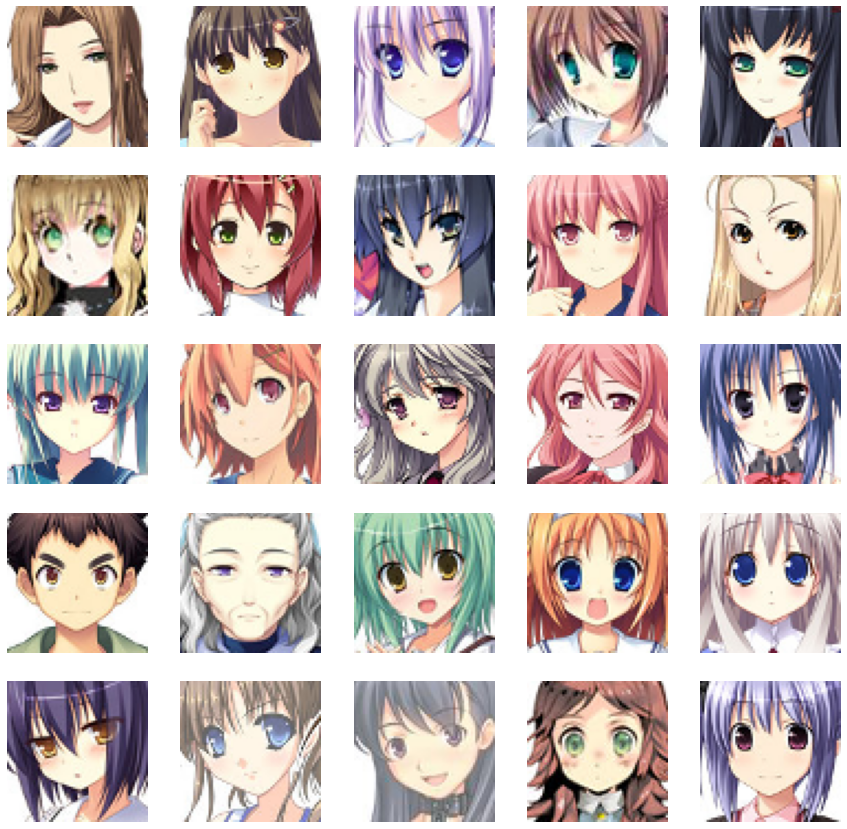

In [ ]:
BASE_DIR = "images"

images = os.listdir(BASE_DIR)


_,ax = plt.subplots(5,5,figsize = (15,15))

for i in range(5):

  for j in range(5):

    path = os.path.join(BASE_DIR,images[5*i+j])

    image = cv2.imread(path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax[i,j].imshow(image)

    ax[i,j].axis('off')









In [ ]:
class GAN():

  def __init__(self):

    self.img_shape = (64,64,3)

    self.path = "images"

    self.noise_shape = (100,)

    optimizer = Adam(learning_rate=0.0002,beta_1=0.5)

    self.generator = self.build_generator()

    self.generator.compile(loss="binary_crossentropy",optimizer=optimizer)

    self.discriminator = self.build_discriminator()

    self.discriminator.compile(loss="binary_crossentropy",optimizer=optimizer)

    self.GAN = Sequential()

    self.GAN.add(self.generator)

    self.GAN.add(self.discriminator)

    self.discriminator.trainable = False

    self.GAN.compile(loss="binary_crossentropy",optimizer=optimizer)

    print(self.GAN.summary())
    
  
  def build_generator(self):

    epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
    noise_shape = (100,)
    
    model = Sequential()
    
    model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 512)))
    
    model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

    # Standard activation for the generator of a GAN
    model.add(Activation("tanh"))

    noise = Input(shape = noise_shape)

    img = model(noise)

    return Model(noise,img)

  def build_discriminator(self):

    model = Sequential()
    model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=self.img_shape)

    validity = model(img)

    return Model(img, validity)

  def show_generated_images(self,epoch):

    noise = np.random.normal(0,1,(25,self.noise_shape[0]))

    generated_images = self.generator.predict(noise)

    generated_images = (generated_images + 1) * 127.5

    generated_images = generated_images.astype(np.uint8)

    fig, axs = plt.subplots(5,5, figsize = (10,10))

    for i in range(5):

      for j in range(5):

        axs[i,j].imshow(generated_images[5*i + j])

        axs[i,j].axis('off')


    fig.show()

    fig.savefig("animeGenerated/Faces_{}.png".format(epoch))

    plt.show()


  def load_data(self):

    images = os.listdir(self.path)

    read_images = [cv2.imread(os.path.join(BASE_DIR,image)) for image in images]

    read_images = [cv2.resize(image,(64,64)) for image in read_images]

    read_images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in read_images]

    plt.imshow(read_images[0])

    plt.show()

    return read_images



  def train(self,epochs,batch_size = 64):

    X_train = self.load_data()

    X_train = np.array(X_train)

    X_train = (X_train.astype(np.float32) - 127.5)/127.5

    discriminator_loss = np.empty(shape = 1)

    generator_loss = np.empty(shape = 1)

    batches = np.empty(shape = 1)

    train_size = len(X_train)//64

    no_of_batches = train_size

    train_size = train_size*64

    X_train = X_train[:train_size]

    plt.ion()

    for epoch in range(epochs):

      print("Epoch " + str(epoch + 1) + "/" + str(epochs) + " :")

      batch_number = 0

      for i in range(0,train_size,batch_size):

        start_time = time.time()

        input_data = X_train[i:i+batch_size]

        noise = np.random.normal(0,1,(batch_size,self.noise_shape[0]))

        generated_images = self.generator.predict(noise)

        self.discriminator.trainable = True

        d_loss = 0

        d_loss = self.discriminator.train_on_batch(input_data, np.ones((batch_size, 1)))

        d_loss += self.discriminator.train_on_batch(generated_images, np.zeros((batch_size, 1)))

        discriminator_loss = np.append(discriminator_loss, d_loss)

        self.discriminator.trainable = False

        noise = np.random.normal(0,1,(2*batch_size,self.noise_shape[0]))

        fake_ones = np.ones((2*batch_size,1))

        g_loss = self.GAN.train_on_batch(noise,fake_ones)

        batches = np.append(batches, batch_number)

        generator_loss = np.append(generator_loss, g_loss)

        time_elapsed = time.time() - start_time

        print("Batch " + str(batch_number + 1) + "/" + str(no_of_batches) + " generator loss | discriminator loss : " + str(g_loss) + " | " + str(d_loss) + ' - batch took ' + str(time_elapsed) + ' s.')

        if epoch % 5 == 0 and (batch_number + 1) == 78:

          self.show_generated_images(epoch)

        batch_number += 1

      plt.figure(1)

      generator_loss = generator_loss[:(epoch+1)*78]

      discriminator_loss = discriminator_loss[:(epoch+1)*78]

      plt.plot(batches[1:], generator_loss, color='green',label='Generator Loss')
      
      plt.plot(batches[1:], discriminator_loss, color='blue',label='Discriminator Loss')
      
      plt.title("GAN Training")
      
      plt.xlabel("Batch Iteration")
      
      plt.ylabel("Loss")

      if epoch == 0:

          plt.legend()

      plt.pause(0.0000000001)
      
      plt.show()
      
      plt.savefig('trainingLossPlot.png')

      if epoch % 10 == 0:

        model.save("/content/gdrive/My Drive/Anime_GAN_models/model_saved_at_epoch {}".format(epoch+1))




Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 64, 64, 3)         7782083   
_________________________________________________________________
model_3 (Model)              (None, 1)                 1267969   
Total params: 9,050,052
Trainable params: 7,780,163
Non-trainable params: 1,269,889
_________________________________________________________________
None


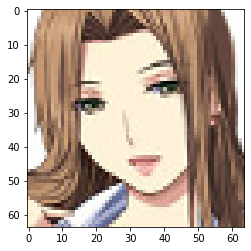

Epoch 1/2000 :
Batch 1/78 generator loss | discriminator loss : 0.6675401926040649 | 7.946161270141602 - batch took 6.20325231552124 s.
Batch 2/78 generator loss | discriminator loss : 0.7131561636924744 | 0.6983883082866669 - batch took 0.9756920337677002 s.
Batch 3/78 generator loss | discriminator loss : 0.6960380673408508 | 1.018831193447113 - batch took 0.9636003971099854 s.
Batch 4/78 generator loss | discriminator loss : 0.6900111436843872 | 0.4009608179330826 - batch took 0.9684691429138184 s.
Batch 5/78 generator loss | discriminator loss : 0.6849467754364014 | 0.22853097319602966 - batch took 0.9653973579406738 s.
Batch 6/78 generator loss | discriminator loss : 0.6709532737731934 | 0.20928654819726944 - batch took 0.9623162746429443 s.
Batch 7/78 generator loss | discriminator loss : 0.6535359025001526 | 0.15035873278975487 - batch took 0.9594895839691162 s.
Batch 8/78 generator loss | discriminator loss : 0.6418523788452148 | 0.09878284111618996 - batch took 0.9576871395111

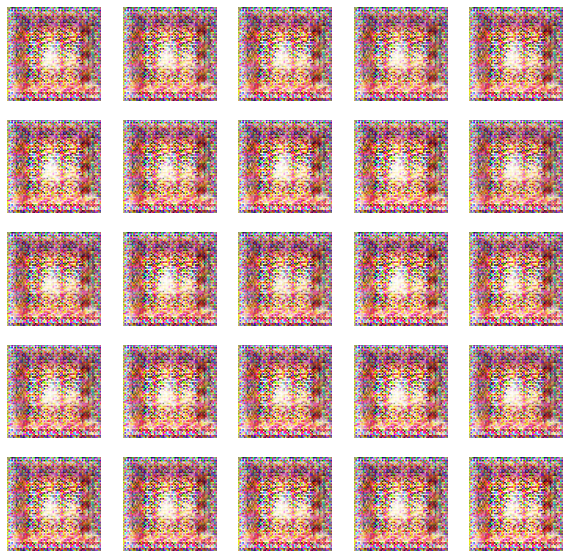

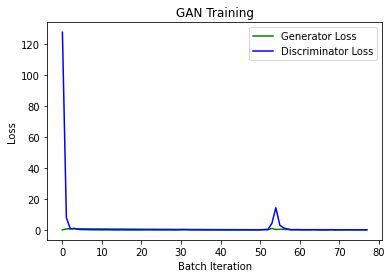

Epoch 2/2000 :
Batch 1/78 generator loss | discriminator loss : 0.07198173552751541 | 0.02858884632587433 - batch took 0.9825007915496826 s.
Batch 2/78 generator loss | discriminator loss : 0.07285889983177185 | 0.012715477030724287 - batch took 0.9761176109313965 s.
Batch 3/78 generator loss | discriminator loss : 0.07006381452083588 | 0.027476072311401367 - batch took 0.9831857681274414 s.
Batch 4/78 generator loss | discriminator loss : 0.06567651033401489 | 0.014396889135241508 - batch took 0.9798007011413574 s.
Batch 5/78 generator loss | discriminator loss : 0.06401245296001434 | 0.016995658166706562 - batch took 0.9769163131713867 s.
Batch 6/78 generator loss | discriminator loss : 0.06572730094194412 | 0.022036713548004627 - batch took 0.977165937423706 s.
Batch 7/78 generator loss | discriminator loss : 0.06126580759882927 | 0.01950801257044077 - batch took 0.9877183437347412 s.
Batch 8/78 generator loss | discriminator loss : 0.060789383947849274 | 0.011408538091927767 - batc

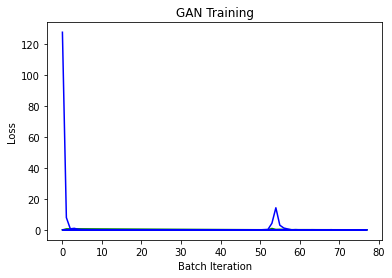

Epoch 3/2000 :
Batch 1/78 generator loss | discriminator loss : 0.0065750679932534695 | 0.011331602465361357 - batch took 0.9752812385559082 s.
Batch 2/78 generator loss | discriminator loss : 0.006273930426687002 | 0.007224205648526549 - batch took 0.9756319522857666 s.
Batch 3/78 generator loss | discriminator loss : 0.005792914889752865 | 0.010854510823264718 - batch took 0.9745728969573975 s.
Batch 4/78 generator loss | discriminator loss : 0.006468122825026512 | 0.003021883254405111 - batch took 0.9701151847839355 s.
Batch 5/78 generator loss | discriminator loss : 0.005930265411734581 | 0.0035301712341606617 - batch took 0.9712834358215332 s.
Batch 6/78 generator loss | discriminator loss : 0.006792879663407803 | 0.003531757043674588 - batch took 0.9842281341552734 s.
Batch 7/78 generator loss | discriminator loss : 0.006054173223674297 | 0.004002150613814592 - batch took 0.9774901866912842 s.
Batch 8/78 generator loss | discriminator loss : 0.0066063120029866695 | 0.002715300885

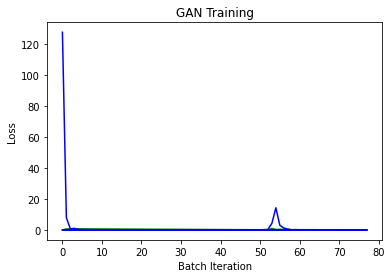

Epoch 4/2000 :
Batch 1/78 generator loss | discriminator loss : 0.001468501752242446 | 0.0037016522837802768 - batch took 0.9684715270996094 s.
Batch 2/78 generator loss | discriminator loss : 0.001533141708932817 | 0.0051174224354326725 - batch took 0.969764232635498 s.
Batch 3/78 generator loss | discriminator loss : 0.0014417213387787342 | 0.003407468553632498 - batch took 0.9746377468109131 s.
Batch 4/78 generator loss | discriminator loss : 0.0015991067048162222 | 0.0025660856044851243 - batch took 0.977114200592041 s.
Batch 5/78 generator loss | discriminator loss : 0.0017403536476194859 | 0.0037779328413307667 - batch took 0.9732770919799805 s.
Batch 6/78 generator loss | discriminator loss : 0.0015161687042564154 | 0.003472181037068367 - batch took 0.9755916595458984 s.
Batch 7/78 generator loss | discriminator loss : 0.0017777049215510488 | 0.0033712652511894703 - batch took 0.9799885749816895 s.
Batch 8/78 generator loss | discriminator loss : 0.0016879313625395298 | 0.001437

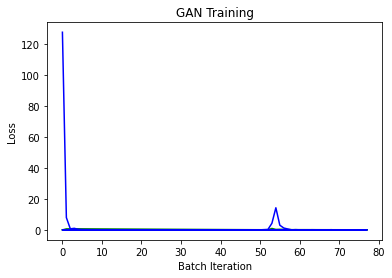

Epoch 5/2000 :
Batch 1/78 generator loss | discriminator loss : 0.00025991114671342075 | 0.0006492822722066194 - batch took 0.9727473258972168 s.
Batch 2/78 generator loss | discriminator loss : 0.0002072787465294823 | 0.000993648893199861 - batch took 0.975806713104248 s.
Batch 3/78 generator loss | discriminator loss : 0.00021882454166188836 | 0.000789566314779222 - batch took 0.981940507888794 s.
Batch 4/78 generator loss | discriminator loss : 0.0001947931741597131 | 0.0004983905382687226 - batch took 0.9776661396026611 s.
Batch 5/78 generator loss | discriminator loss : 0.0001742398162605241 | 0.0015394437941722572 - batch took 0.970667839050293 s.
Batch 6/78 generator loss | discriminator loss : 0.00021314369223546237 | 0.0006826132885180414 - batch took 0.9823431968688965 s.
Batch 7/78 generator loss | discriminator loss : 0.00018240294593852013 | 0.0005912497872486711 - batch took 0.972527027130127 s.
Batch 8/78 generator loss | discriminator loss : 0.00019835811690427363 | 0.0

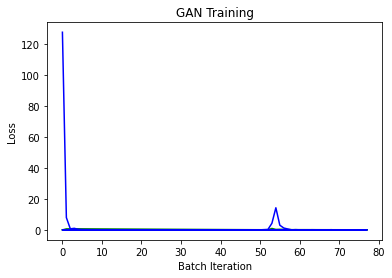

Epoch 6/2000 :
Batch 1/78 generator loss | discriminator loss : 6.13357187830843e-05 | 0.00025764958263607696 - batch took 0.9624588489532471 s.
Batch 2/78 generator loss | discriminator loss : 4.575331695377827e-05 | 0.000298828243103344 - batch took 0.971550703048706 s.
Batch 3/78 generator loss | discriminator loss : 4.4621127017308027e-05 | 0.00023358588077826425 - batch took 0.9772837162017822 s.
Batch 4/78 generator loss | discriminator loss : 4.1066719859372824e-05 | 0.00018162866035709158 - batch took 0.9678678512573242 s.
Batch 5/78 generator loss | discriminator loss : 5.373576277634129e-05 | 0.000243554066400975 - batch took 0.9703578948974609 s.
Batch 6/78 generator loss | discriminator loss : 3.4849465009756386e-05 | 0.00037922951742075384 - batch took 0.973935604095459 s.
Batch 7/78 generator loss | discriminator loss : 5.21011752425693e-05 | 0.00014218642900232226 - batch took 0.964280366897583 s.
Batch 8/78 generator loss | discriminator loss : 5.390965088736266e-05 | 0

<Figure size 432x288 with 0 Axes>

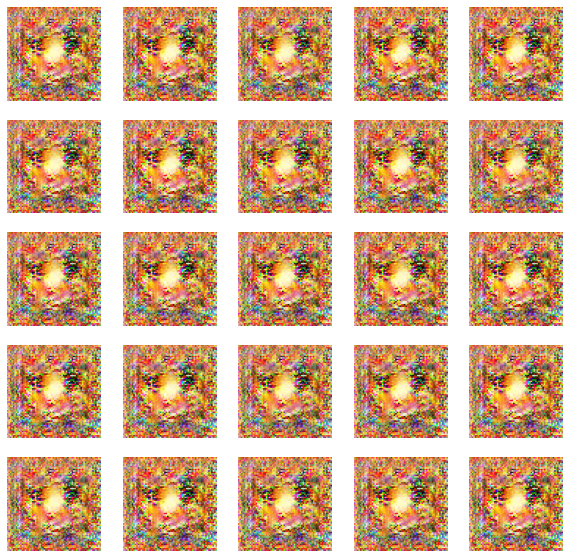

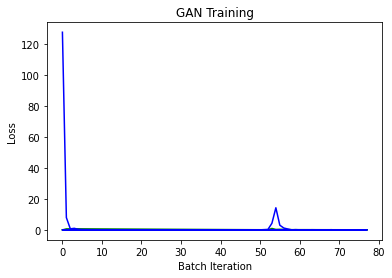

Epoch 7/2000 :
Batch 1/78 generator loss | discriminator loss : 2.7083071472588927e-05 | 0.00012702673120656982 - batch took 0.9827837944030762 s.
Batch 2/78 generator loss | discriminator loss : 2.628659967740532e-05 | 0.0002804256109811831 - batch took 0.9658081531524658 s.
Batch 3/78 generator loss | discriminator loss : 2.5017125153681263e-05 | 0.00016484493244206533 - batch took 0.976266622543335 s.
Batch 4/78 generator loss | discriminator loss : 2.180822593800258e-05 | 0.0001680149980529677 - batch took 0.9649579524993896 s.
Batch 5/78 generator loss | discriminator loss : 2.394005969108548e-05 | 0.00014406229456653818 - batch took 0.9673688411712646 s.
Batch 6/78 generator loss | discriminator loss : 2.875467725971248e-05 | 0.0001299981086049229 - batch took 0.9795413017272949 s.
Batch 7/78 generator loss | discriminator loss : 2.38295724557247e-05 | 0.00011410848674131557 - batch took 0.9672834873199463 s.
Batch 8/78 generator loss | discriminator loss : 2.7180409233551472e-05

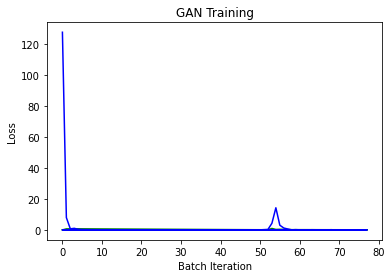

Epoch 8/2000 :
Batch 1/78 generator loss | discriminator loss : 1.835738294175826e-05 | 0.00012720218364847824 - batch took 0.9607663154602051 s.
Batch 2/78 generator loss | discriminator loss : 1.8044185708276927e-05 | 0.0001364579402434174 - batch took 0.9658496379852295 s.
Batch 3/78 generator loss | discriminator loss : 1.697578773018904e-05 | 9.623959522286896e-05 - batch took 0.98541259765625 s.
Batch 4/78 generator loss | discriminator loss : 1.9621455066953786e-05 | 8.845050251693465e-05 - batch took 0.9690289497375488 s.
Batch 5/78 generator loss | discriminator loss : 2.2773416276322678e-05 | 0.00010466441017342731 - batch took 0.9771578311920166 s.
Batch 6/78 generator loss | discriminator loss : 1.8763636035146192e-05 | 0.00011690637256833725 - batch took 0.9737234115600586 s.
Batch 7/78 generator loss | discriminator loss : 1.6370395314879715e-05 | 6.864799433969893e-05 - batch took 0.9677431583404541 s.
Batch 8/78 generator loss | discriminator loss : 2.0786217646673322e-

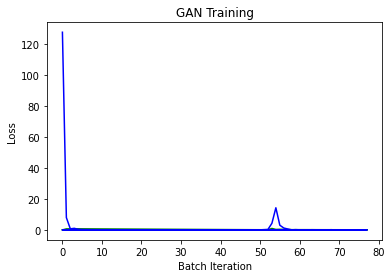

Epoch 9/2000 :
Batch 1/78 generator loss | discriminator loss : 1.7204405594384298e-05 | 7.08517382008722e-05 - batch took 0.9613103866577148 s.
Batch 2/78 generator loss | discriminator loss : 1.8469254428055137e-05 | 0.00010932205623248592 - batch took 0.9706172943115234 s.
Batch 3/78 generator loss | discriminator loss : 2.241033871541731e-05 | 8.349608287971932e-05 - batch took 0.9739525318145752 s.
Batch 4/78 generator loss | discriminator loss : 1.4718301827087998e-05 | 0.00010397801088402048 - batch took 0.976567268371582 s.
Batch 5/78 generator loss | discriminator loss : 1.6788513676146977e-05 | 4.664799416786991e-05 - batch took 0.970097541809082 s.
Batch 6/78 generator loss | discriminator loss : 1.3158994988771155e-05 | 8.948148024501279e-05 - batch took 0.9716939926147461 s.
Batch 7/78 generator loss | discriminator loss : 1.581017568241805e-05 | 5.547097862290684e-05 - batch took 0.9685165882110596 s.
Batch 8/78 generator loss | discriminator loss : 1.8063472452922724e-05

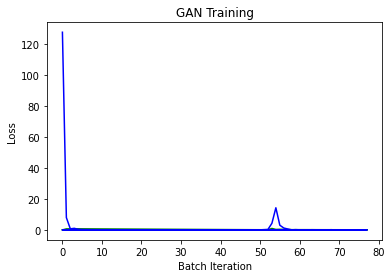

Epoch 10/2000 :
Batch 1/78 generator loss | discriminator loss : 1.3045495506958105e-05 | 5.3381550969788805e-05 - batch took 0.9714150428771973 s.
Batch 2/78 generator loss | discriminator loss : 1.698756022960879e-05 | 6.968526031414513e-05 - batch took 0.9697725772857666 s.
Batch 3/78 generator loss | discriminator loss : 1.560424243507441e-05 | 0.00015613158757332712 - batch took 0.9675626754760742 s.
Batch 4/78 generator loss | discriminator loss : 1.3517793377104681e-05 | 3.4130432140955236e-05 - batch took 0.9669678211212158 s.
Batch 5/78 generator loss | discriminator loss : 1.390026773151476e-05 | 0.0001047881378326565 - batch took 0.9654479026794434 s.
Batch 6/78 generator loss | discriminator loss : 1.3265138477436267e-05 | 6.655962715740316e-05 - batch took 0.9737086296081543 s.
Batch 7/78 generator loss | discriminator loss : 1.2930453522130847e-05 | 8.269126919913106e-05 - batch took 0.9706211090087891 s.
Batch 8/78 generator loss | discriminator loss : 1.220285048475489e

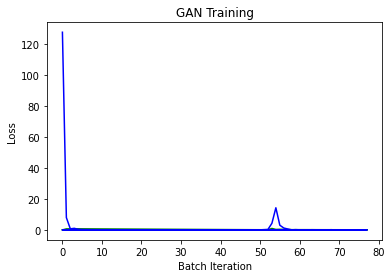

Epoch 11/2000 :
Batch 1/78 generator loss | discriminator loss : 1.0403320629848167e-05 | 5.896231050428469e-05 - batch took 0.9652698040008545 s.
Batch 2/78 generator loss | discriminator loss : 1.2629043339984491e-05 | 2.832139125530375e-05 - batch took 0.9735603332519531 s.
Batch 3/78 generator loss | discriminator loss : 1.3734449566982221e-05 | 4.722995436168276e-05 - batch took 0.9674727916717529 s.
Batch 4/78 generator loss | discriminator loss : 1.1918651580344886e-05 | 3.646652476163581e-05 - batch took 0.973008394241333 s.
Batch 5/78 generator loss | discriminator loss : 1.0190880857408047e-05 | 3.0898214390617795e-05 - batch took 0.9724750518798828 s.
Batch 6/78 generator loss | discriminator loss : 1.1890443602169398e-05 | 6.130032670625951e-05 - batch took 0.9735136032104492 s.
Batch 7/78 generator loss | discriminator loss : 1.0757664313132409e-05 | 3.396646752662491e-05 - batch took 0.9712278842926025 s.
Batch 8/78 generator loss | discriminator loss : 1.1443428775237408

<Figure size 432x288 with 0 Axes>

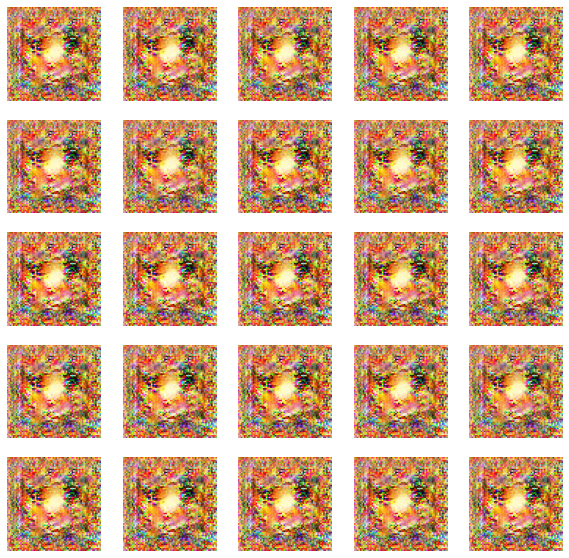

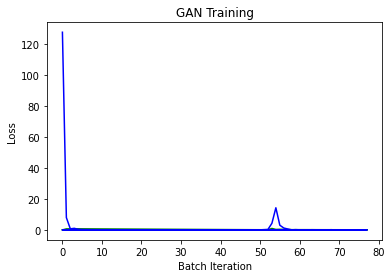

Epoch 12/2000 :
Batch 1/78 generator loss | discriminator loss : 8.22368292574538e-06 | 5.560654608416371e-05 - batch took 0.9804778099060059 s.
Batch 2/78 generator loss | discriminator loss : 1.0285484677297063e-05 | 2.6690700906328857e-05 - batch took 0.9770290851593018 s.
Batch 3/78 generator loss | discriminator loss : 1.0780511729535647e-05 | 3.727600324054947e-05 - batch took 0.9814891815185547 s.
Batch 4/78 generator loss | discriminator loss : 9.371575288241729e-06 | 3.9621226278541144e-05 - batch took 0.9730339050292969 s.
Batch 5/78 generator loss | discriminator loss : 9.821002095122822e-06 | 2.7492338631418534e-05 - batch took 0.9634454250335693 s.
Batch 6/78 generator loss | discriminator loss : 1.073699149856111e-05 | 3.971149453718681e-05 - batch took 0.9687786102294922 s.
Batch 7/78 generator loss | discriminator loss : 9.680247785581741e-06 | 2.5117015866271686e-05 - batch took 0.96980881690979 s.
Batch 8/78 generator loss | discriminator loss : 1.0384466804680414e-05

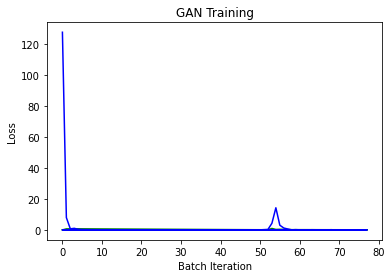

Epoch 13/2000 :
Batch 1/78 generator loss | discriminator loss : 9.195398888550699e-06 | 2.7098707505501807e-05 - batch took 0.9708209037780762 s.
Batch 2/78 generator loss | discriminator loss : 6.511537321784999e-06 | 5.608613173535559e-05 - batch took 0.9701616764068604 s.
Batch 3/78 generator loss | discriminator loss : 7.115015250747092e-06 | 3.546545667632017e-05 - batch took 0.9643323421478271 s.
Batch 4/78 generator loss | discriminator loss : 8.30386852612719e-06 | 2.7883643269888125e-05 - batch took 0.9767186641693115 s.
Batch 5/78 generator loss | discriminator loss : 8.792279004410375e-06 | 3.3046369935618713e-05 - batch took 0.971599817276001 s.
Batch 6/78 generator loss | discriminator loss : 8.006156349438243e-06 | 3.110260877292603e-05 - batch took 0.9681713581085205 s.
Batch 7/78 generator loss | discriminator loss : 8.326708666572813e-06 | 2.4914105779316742e-05 - batch took 0.9671885967254639 s.
Batch 8/78 generator loss | discriminator loss : 8.06354364613071e-06 | 

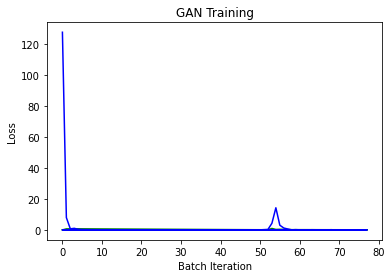

Epoch 14/2000 :
Batch 1/78 generator loss | discriminator loss : 6.919338829902699e-06 | 3.3744156098691747e-05 - batch took 0.9644792079925537 s.
Batch 2/78 generator loss | discriminator loss : 4.875703780271579e-06 | 0.0006397273173206486 - batch took 0.9729721546173096 s.
Batch 3/78 generator loss | discriminator loss : 4.031720436614705e-06 | 3.439596821408486e-05 - batch took 0.9775080680847168 s.
Batch 4/78 generator loss | discriminator loss : 5.192950538912555e-06 | 2.8840358936577104e-05 - batch took 0.9770762920379639 s.
Batch 5/78 generator loss | discriminator loss : 4.762250682688318e-06 | 2.7845706426887773e-05 - batch took 0.9742739200592041 s.
Batch 6/78 generator loss | discriminator loss : 4.469578925636597e-06 | 2.7138818950334098e-05 - batch took 0.9747867584228516 s.
Batch 7/78 generator loss | discriminator loss : 4.883411747869104e-06 | 3.394039867998799e-05 - batch took 0.9837703704833984 s.
Batch 8/78 generator loss | discriminator loss : 7.270081368915271e-06

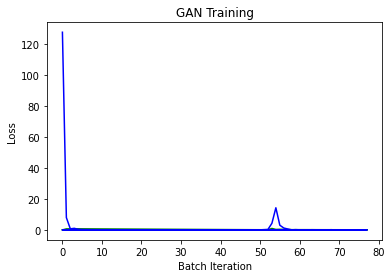

Epoch 15/2000 :
Batch 1/78 generator loss | discriminator loss : 5.584066457231529e-06 | 2.1121293684700504e-05 - batch took 0.9694750308990479 s.
Batch 2/78 generator loss | discriminator loss : 5.804206921311561e-06 | 2.5261323571612593e-05 - batch took 0.9727301597595215 s.
Batch 3/78 generator loss | discriminator loss : 1.0107721209351439e-05 | 7.462438225047663e-05 - batch took 0.9674746990203857 s.
Batch 4/78 generator loss | discriminator loss : 5.314882400853094e-06 | 1.7117605239036493e-05 - batch took 0.9739687442779541 s.
Batch 5/78 generator loss | discriminator loss : 6.538809884659713e-06 | 2.8679366550932173e-05 - batch took 0.9719889163970947 s.
Batch 6/78 generator loss | discriminator loss : 7.988724973984063e-06 | 1.7652774658927228e-05 - batch took 0.9752278327941895 s.
Batch 7/78 generator loss | discriminator loss : 6.4719479269115254e-06 | 1.854081347119063e-05 - batch took 0.9753193855285645 s.
Batch 8/78 generator loss | discriminator loss : 6.525184289785102e

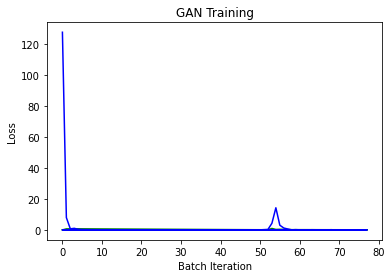

Epoch 16/2000 :
Batch 1/78 generator loss | discriminator loss : 6.873347956570797e-06 | 2.9308494049473666e-05 - batch took 0.9670698642730713 s.
Batch 2/78 generator loss | discriminator loss : 6.717587893945165e-06 | 1.8601804185891524e-05 - batch took 0.9648656845092773 s.
Batch 3/78 generator loss | discriminator loss : 4.746522790810559e-06 | 1.6857356513355626e-05 - batch took 0.9790849685668945 s.
Batch 4/78 generator loss | discriminator loss : 5.2494406190817244e-06 | 2.7006195523426868e-05 - batch took 0.9788823127746582 s.
Batch 5/78 generator loss | discriminator loss : 5.988282282487489e-06 | 1.5747072211524937e-05 - batch took 0.9717011451721191 s.
Batch 6/78 generator loss | discriminator loss : 7.558869583590422e-06 | 2.2299792362900916e-05 - batch took 0.9749128818511963 s.
Batch 7/78 generator loss | discriminator loss : 6.700675839965697e-06 | 1.8913163330580574e-05 - batch took 0.976902961730957 s.
Batch 8/78 generator loss | discriminator loss : 6.18368039795314e-

<Figure size 432x288 with 0 Axes>

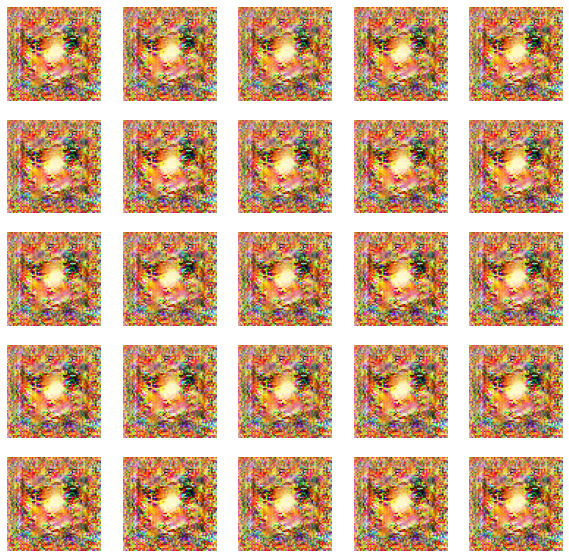

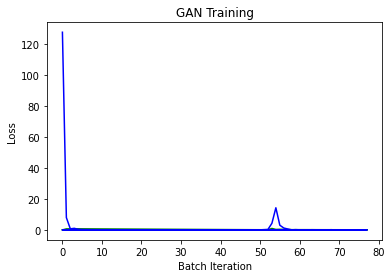

Epoch 17/2000 :
Batch 1/78 generator loss | discriminator loss : 3.85715247830376e-06 | 1.319176226388663e-05 - batch took 0.9815459251403809 s.
Batch 2/78 generator loss | discriminator loss : 6.453224159486126e-06 | 1.8468951566319447e-05 - batch took 0.9789867401123047 s.
Batch 3/78 generator loss | discriminator loss : 4.691826234193286e-06 | 3.3002042982843705e-05 - batch took 0.96429443359375 s.
Batch 4/78 generator loss | discriminator loss : 5.877773219253868e-06 | 1.4468701692749164e-05 - batch took 0.9607741832733154 s.
Batch 5/78 generator loss | discriminator loss : 6.298912467173068e-06 | 1.224180141434772e-05 - batch took 0.9794113636016846 s.
Batch 6/78 generator loss | discriminator loss : 4.4381831685313955e-06 | 1.352213803329505e-05 - batch took 0.9675540924072266 s.
Batch 7/78 generator loss | discriminator loss : 5.891211003472563e-06 | 1.4034732430445729e-05 - batch took 0.9696376323699951 s.
Batch 8/78 generator loss | discriminator loss : 6.277615284489002e-06 |

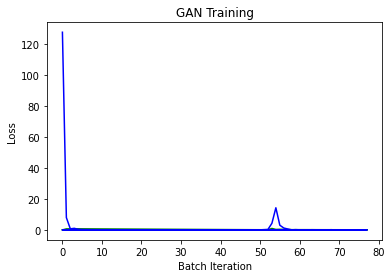

Epoch 18/2000 :
Batch 1/78 generator loss | discriminator loss : 3.586658749554772e-06 | 2.047431917162612e-05 - batch took 0.9709377288818359 s.
Batch 2/78 generator loss | discriminator loss : 5.668322955898475e-06 | 1.2328754564805422e-05 - batch took 0.9705488681793213 s.
Batch 3/78 generator loss | discriminator loss : 5.2632508413807955e-06 | 2.5363731765537523e-05 - batch took 0.9750640392303467 s.
Batch 4/78 generator loss | discriminator loss : 4.496760084293783e-06 | 1.5972719666024204e-05 - batch took 0.9721903800964355 s.
Batch 5/78 generator loss | discriminator loss : 5.7930783441406675e-06 | 1.079963749361923e-05 - batch took 0.9672753810882568 s.
Batch 6/78 generator loss | discriminator loss : 4.704966613644501e-06 | 1.3754890915151918e-05 - batch took 0.9707062244415283 s.
Batch 7/78 generator loss | discriminator loss : 3.990448021795601e-06 | 1.1642915524134878e-05 - batch took 0.9669749736785889 s.
Batch 8/78 generator loss | discriminator loss : 4.394456027512206e

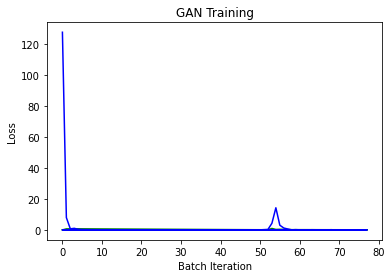

Epoch 19/2000 :
Batch 1/78 generator loss | discriminator loss : 4.476350568438647e-06 | 1.4158265457808739e-05 - batch took 0.9722855091094971 s.
Batch 2/78 generator loss | discriminator loss : 3.280694500062964e-06 | 9.143760280494462e-06 - batch took 0.9759435653686523 s.
Batch 3/78 generator loss | discriminator loss : 3.7817305837961612e-06 | 1.3286637113196775e-05 - batch took 0.9735538959503174 s.
Batch 4/78 generator loss | discriminator loss : 3.726006980286911e-06 | 1.0786331358758616e-05 - batch took 0.9620637893676758 s.
Batch 5/78 generator loss | discriminator loss : 4.055137651448604e-06 | 1.0678635135263903e-05 - batch took 0.9731144905090332 s.
Batch 6/78 generator loss | discriminator loss : 3.8632479117950425e-06 | 1.5173353858699556e-05 - batch took 0.9736387729644775 s.
Batch 7/78 generator loss | discriminator loss : 4.168230134382611e-06 | 1.0925703918474028e-05 - batch took 0.9667024612426758 s.
Batch 8/78 generator loss | discriminator loss : 4.637483925762353

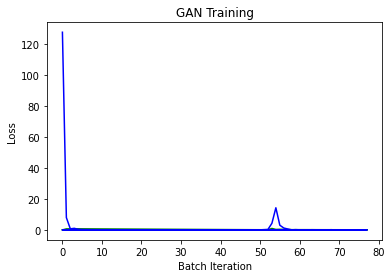

Epoch 20/2000 :
Batch 1/78 generator loss | discriminator loss : 3.4224638056912227e-06 | 9.489294370723655e-06 - batch took 0.9673373699188232 s.
Batch 2/78 generator loss | discriminator loss : 3.252412852816633e-06 | 9.56823578235344e-06 - batch took 0.9687213897705078 s.
Batch 3/78 generator loss | discriminator loss : 3.391435711819213e-06 | 9.508094535704004e-06 - batch took 0.9636094570159912 s.
Batch 4/78 generator loss | discriminator loss : 2.901108928199392e-06 | 1.2270187198737403e-05 - batch took 0.9693143367767334 s.
Batch 5/78 generator loss | discriminator loss : 3.4390493510727538e-06 | 1.1974096196354367e-05 - batch took 0.968308687210083 s.
Batch 6/78 generator loss | discriminator loss : 3.542306103554438e-06 | 8.639483439765172e-06 - batch took 0.971160888671875 s.
Batch 7/78 generator loss | discriminator loss : 3.5337748158781324e-06 | 6.390585213011946e-06 - batch took 0.9759421348571777 s.
Batch 8/78 generator loss | discriminator loss : 3.350369979671086e-06 |

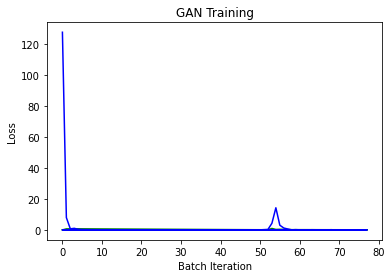

Epoch 21/2000 :
Batch 1/78 generator loss | discriminator loss : 2.49504046223592e-06 | 1.3305291304277489e-05 - batch took 0.9735879898071289 s.
Batch 2/78 generator loss | discriminator loss : 3.3747596717148554e-06 | 7.434997769451002e-06 - batch took 0.9734005928039551 s.
Batch 3/78 generator loss | discriminator loss : 2.931282551799086e-06 | 2.7878783612322877e-05 - batch took 0.9691717624664307 s.
Batch 4/78 generator loss | discriminator loss : 3.2911652851908e-06 | 1.5003106000222033e-05 - batch took 0.9725513458251953 s.
Batch 5/78 generator loss | discriminator loss : 2.6328866624680813e-06 | 7.824773547326913e-06 - batch took 0.9760525226593018 s.
Batch 6/78 generator loss | discriminator loss : 3.3838718991319183e-06 | 9.66846891969908e-06 - batch took 0.9727566242218018 s.
Batch 7/78 generator loss | discriminator loss : 2.784052867355058e-06 | 7.997132115633576e-06 - batch took 0.9703388214111328 s.
Batch 8/78 generator loss | discriminator loss : 2.8856786684627878e-06 

<Figure size 432x288 with 0 Axes>

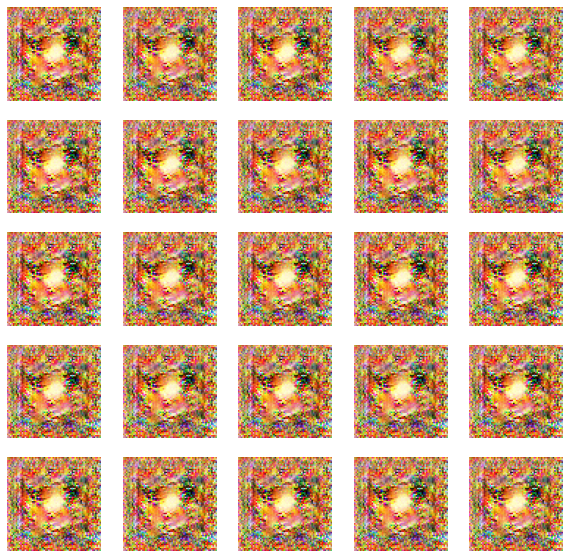

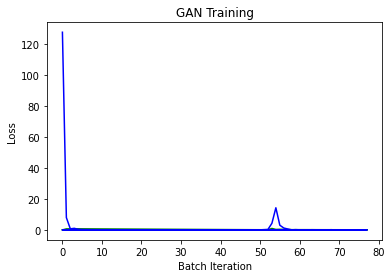

Epoch 22/2000 :
Batch 1/78 generator loss | discriminator loss : 2.1620069219352445e-06 | 6.986397693253821e-06 - batch took 0.9722466468811035 s.
Batch 2/78 generator loss | discriminator loss : 2.9938296393083874e-06 | 8.08059235168912e-06 - batch took 0.9694356918334961 s.
Batch 3/78 generator loss | discriminator loss : 3.1765030144015327e-06 | 9.145097465079743e-06 - batch took 0.9763064384460449 s.
Batch 4/78 generator loss | discriminator loss : 2.6225136480206857e-06 | 6.8063236540183425e-06 - batch took 0.9721450805664062 s.
Batch 5/78 generator loss | discriminator loss : 2.0183292690489907e-06 | 8.473371963191312e-06 - batch took 0.9779930114746094 s.
Batch 6/78 generator loss | discriminator loss : 2.5609419935790356e-06 | 1.324138088421023e-05 - batch took 0.9686183929443359 s.
Batch 7/78 generator loss | discriminator loss : 2.4442103949695593e-06 | 6.934860948604182e-06 - batch took 0.9650518894195557 s.
Batch 8/78 generator loss | discriminator loss : 2.261743702547392e

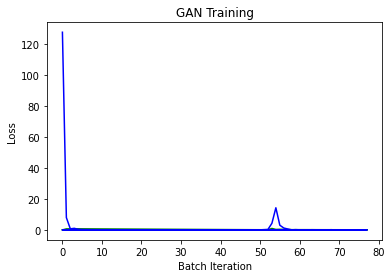

Epoch 23/2000 :
Batch 1/78 generator loss | discriminator loss : 2.101410245813895e-06 | 7.2993723279068945e-06 - batch took 1.1935784816741943 s.
Batch 2/78 generator loss | discriminator loss : 1.8746738987829303e-06 | 7.172719506343128e-06 - batch took 0.9752249717712402 s.
Batch 3/78 generator loss | discriminator loss : 2.0635934561141767e-06 | 9.91844854070223e-06 - batch took 0.9727911949157715 s.
Batch 4/78 generator loss | discriminator loss : 2.6483837700652657e-06 | 7.32976195649826e-06 - batch took 0.9681088924407959 s.
Batch 5/78 generator loss | discriminator loss : 2.3493921617046e-06 | 4.905555897494196e-06 - batch took 0.9677226543426514 s.
Batch 6/78 generator loss | discriminator loss : 1.7505433334008558e-06 | 7.633147561136866e-06 - batch took 0.976635217666626 s.
Batch 7/78 generator loss | discriminator loss : 1.9616597910498967e-06 | 4.550693574856268e-06 - batch took 0.9678194522857666 s.
Batch 8/78 generator loss | discriminator loss : 2.1790106075059157e-06 |

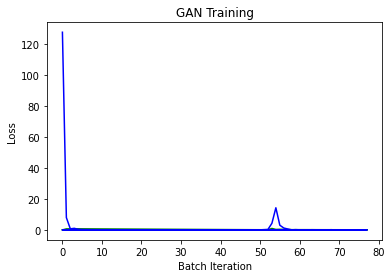

Epoch 24/2000 :
Batch 1/78 generator loss | discriminator loss : 1.796460423975077e-06 | 6.3444118723055e-06 - batch took 0.9748492240905762 s.
Batch 2/78 generator loss | discriminator loss : 2.034227463809657e-06 | 5.487552471095114e-06 - batch took 0.9795196056365967 s.
Batch 3/78 generator loss | discriminator loss : 1.6239970364040346e-06 | 4.511801421358541e-06 - batch took 0.9766631126403809 s.
Batch 4/78 generator loss | discriminator loss : 2.561796236477676e-06 | 6.868686568850535e-06 - batch took 0.9712860584259033 s.
Batch 5/78 generator loss | discriminator loss : 2.4456257960991934e-06 | 6.181652793202375e-06 - batch took 0.9836583137512207 s.
Batch 6/78 generator loss | discriminator loss : 2.423395699224784e-06 | 5.3762928473588545e-06 - batch took 0.9780673980712891 s.
Batch 7/78 generator loss | discriminator loss : 1.9539550066838274e-06 | 3.437621103330457e-06 - batch took 0.9724600315093994 s.
Batch 8/78 generator loss | discriminator loss : 2.6195571081188973e-06 

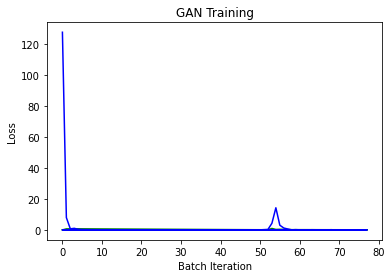

Epoch 25/2000 :
Batch 1/78 generator loss | discriminator loss : 1.7944294086191803e-06 | 1.489871647208929e-05 - batch took 0.985407829284668 s.
Batch 2/78 generator loss | discriminator loss : 2.443269522700575e-06 | 5.00336227560183e-06 - batch took 0.9854090213775635 s.
Batch 3/78 generator loss | discriminator loss : 1.7535212464281358e-06 | 1.0405200782770407e-05 - batch took 0.9857466220855713 s.
Batch 4/78 generator loss | discriminator loss : 2.6239699764118996e-06 | 4.600579131874838e-06 - batch took 0.9743537902832031 s.
Batch 5/78 generator loss | discriminator loss : 1.5814910057088127e-06 | 4.798932423000224e-06 - batch took 0.9805092811584473 s.
Batch 6/78 generator loss | discriminator loss : 1.5196792446658947e-06 | 9.384651093569119e-06 - batch took 0.9815549850463867 s.
Batch 7/78 generator loss | discriminator loss : 1.5684148593209102e-06 | 3.718817538356234e-06 - batch took 0.9754090309143066 s.
Batch 8/78 generator loss | discriminator loss : 1.6238880107266596e-

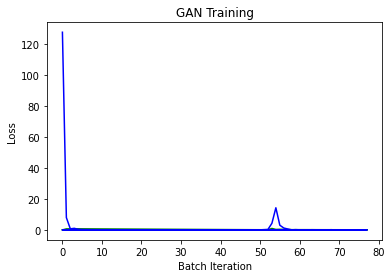

Epoch 26/2000 :
Batch 1/78 generator loss | discriminator loss : 1.4680285858048592e-06 | 5.6545284223830095e-06 - batch took 0.9831101894378662 s.
Batch 2/78 generator loss | discriminator loss : 1.7389870663464535e-06 | 4.799201860805624e-06 - batch took 0.9738414287567139 s.
Batch 3/78 generator loss | discriminator loss : 1.7022759948304156e-06 | 1.1385394827811979e-05 - batch took 0.9799087047576904 s.
Batch 4/78 generator loss | discriminator loss : 1.6615894082860905e-06 | 4.653636665352678e-06 - batch took 0.9802460670471191 s.
Batch 5/78 generator loss | discriminator loss : 1.7953427686734358e-06 | 4.670438215725881e-06 - batch took 0.9854946136474609 s.
Batch 6/78 generator loss | discriminator loss : 1.8105308754456928e-06 | 9.261925242753932e-06 - batch took 0.9709007740020752 s.
Batch 7/78 generator loss | discriminator loss : 1.6659740822433378e-06 | 4.700286353909178e-06 - batch took 0.9791901111602783 s.
Batch 8/78 generator loss | discriminator loss : 1.41073701342975

<Figure size 432x288 with 0 Axes>

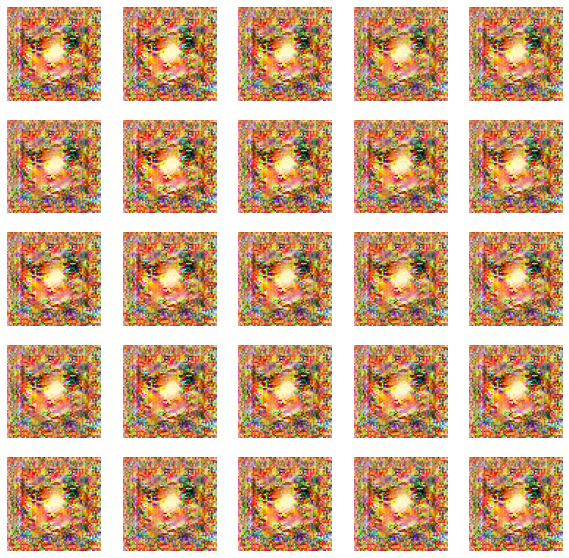

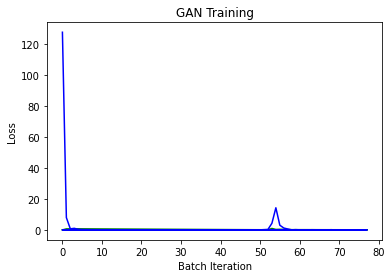

Epoch 27/2000 :
Batch 1/78 generator loss | discriminator loss : 1.5269060895661823e-06 | 6.281269520513888e-06 - batch took 0.9776782989501953 s.
Batch 2/78 generator loss | discriminator loss : 1.431451551070495e-06 | 4.382971951599757e-06 - batch took 0.9776365756988525 s.
Batch 3/78 generator loss | discriminator loss : 1.5917554492261843e-06 | 1.0653077424649382e-05 - batch took 0.9744129180908203 s.
Batch 4/78 generator loss | discriminator loss : 1.5690934560552705e-06 | 3.824626901405281e-06 - batch took 0.9755353927612305 s.
Batch 5/78 generator loss | discriminator loss : 1.496742811468721e-06 | 5.1780963872261054e-06 - batch took 0.9821882247924805 s.
Batch 6/78 generator loss | discriminator loss : 1.452166316084913e-06 | 6.947258043510374e-06 - batch took 0.9806110858917236 s.
Batch 7/78 generator loss | discriminator loss : 1.5367374999186723e-06 | 4.368594090919942e-06 - batch took 0.9841892719268799 s.
Batch 8/78 generator loss | discriminator loss : 1.3471585589286406e

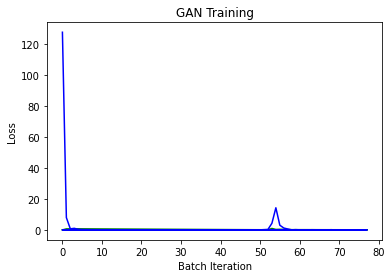

Epoch 28/2000 :
Batch 1/78 generator loss | discriminator loss : 1.5384141534013906e-06 | 4.8072492973005865e-06 - batch took 0.9833583831787109 s.
Batch 2/78 generator loss | discriminator loss : 2.11139808925509e-06 | 4.540936288321973e-06 - batch took 0.9783906936645508 s.
Batch 3/78 generator loss | discriminator loss : 1.8296369717063499e-06 | 4.624347411663621e-06 - batch took 0.9732246398925781 s.
Batch 4/78 generator loss | discriminator loss : 1.498665028520918e-06 | 4.972638180333888e-06 - batch took 0.9764208793640137 s.
Batch 5/78 generator loss | discriminator loss : 1.6795968349470058e-06 | 3.19881155519397e-06 - batch took 0.9788334369659424 s.
Batch 6/78 generator loss | discriminator loss : 1.4670782775283442e-06 | 6.1271960021258565e-06 - batch took 0.9812526702880859 s.
Batch 7/78 generator loss | discriminator loss : 1.5734524367871927e-06 | 2.278771148667147e-06 - batch took 0.9784793853759766 s.
Batch 8/78 generator loss | discriminator loss : 1.3315825526660774e-

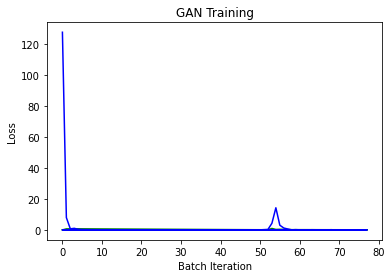

Epoch 29/2000 :
Batch 1/78 generator loss | discriminator loss : 1.9365097614354454e-06 | 5.350978369733639e-06 - batch took 0.9740591049194336 s.
Batch 2/78 generator loss | discriminator loss : 1.2666262136917794e-06 | 2.525334195979667e-06 - batch took 0.9749202728271484 s.
Batch 3/78 generator loss | discriminator loss : 1.0762346391857136e-06 | 6.606818828913674e-06 - batch took 0.98280930519104 s.
Batch 4/78 generator loss | discriminator loss : 1.761498083396873e-06 | 5.125925554239075e-06 - batch took 0.9851164817810059 s.
Batch 5/78 generator loss | discriminator loss : 1.3291752338773222e-06 | 2.303243832102453e-06 - batch took 0.9808197021484375 s.
Batch 6/78 generator loss | discriminator loss : 1.3094600035401527e-06 | 2.603077746243798e-06 - batch took 0.979252815246582 s.
Batch 7/78 generator loss | discriminator loss : 1.1471624929981772e-06 | 3.785890839935746e-06 - batch took 0.9742016792297363 s.
Batch 8/78 generator loss | discriminator loss : 1.4743902738700854e-06

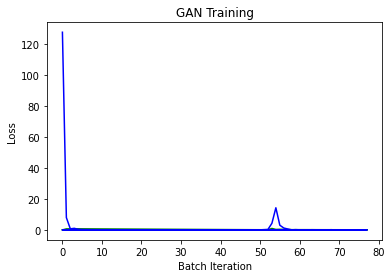

Epoch 30/2000 :
Batch 1/78 generator loss | discriminator loss : 1.1685623348967056e-06 | 3.689283403218724e-06 - batch took 0.96266770362854 s.
Batch 2/78 generator loss | discriminator loss : 1.4382492281583836e-06 | 3.490554661311762e-06 - batch took 0.9826750755310059 s.
Batch 3/78 generator loss | discriminator loss : 1.5704189308962668e-06 | 3.344403125993267e-06 - batch took 0.9800686836242676 s.
Batch 4/78 generator loss | discriminator loss : 1.4032241324457573e-06 | 2.3865889602348034e-06 - batch took 0.9797828197479248 s.
Batch 5/78 generator loss | discriminator loss : 1.2719042388198432e-06 | 2.1403415075837984e-06 - batch took 0.987511396408081 s.
Batch 6/78 generator loss | discriminator loss : 1.3437596635412774e-06 | 3.0506192274515342e-06 - batch took 0.9759941101074219 s.
Batch 7/78 generator loss | discriminator loss : 1.2409304872562643e-06 | 1.8177869947066938e-06 - batch took 0.9802558422088623 s.
Batch 8/78 generator loss | discriminator loss : 1.299047653446905

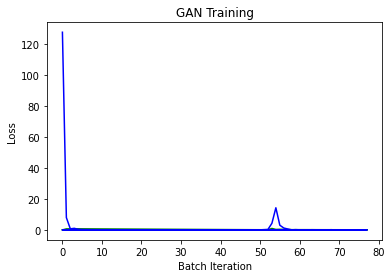

Epoch 31/2000 :
Batch 1/78 generator loss | discriminator loss : 9.927797464115429e-07 | 4.011446208096459e-06 - batch took 0.9823825359344482 s.
Batch 2/78 generator loss | discriminator loss : 1.0675049679775839e-06 | 2.438352737499372e-06 - batch took 0.9761819839477539 s.
Batch 3/78 generator loss | discriminator loss : 1.3146507171768462e-06 | 3.3349792829540092e-06 - batch took 0.972247838973999 s.
Batch 4/78 generator loss | discriminator loss : 1.3851475841875072e-06 | 2.837578108483285e-06 - batch took 0.9781327247619629 s.
Batch 5/78 generator loss | discriminator loss : 1.2511077329691034e-06 | 2.6708884206527728e-06 - batch took 0.9762377738952637 s.
Batch 6/78 generator loss | discriminator loss : 1.0246009196634986e-06 | 3.2098128031066153e-06 - batch took 0.9723877906799316 s.
Batch 7/78 generator loss | discriminator loss : 1.438044478163647e-06 | 2.015232041685522e-06 - batch took 0.9739522933959961 s.
Batch 8/78 generator loss | discriminator loss : 1.126643041970965e

<Figure size 432x288 with 0 Axes>

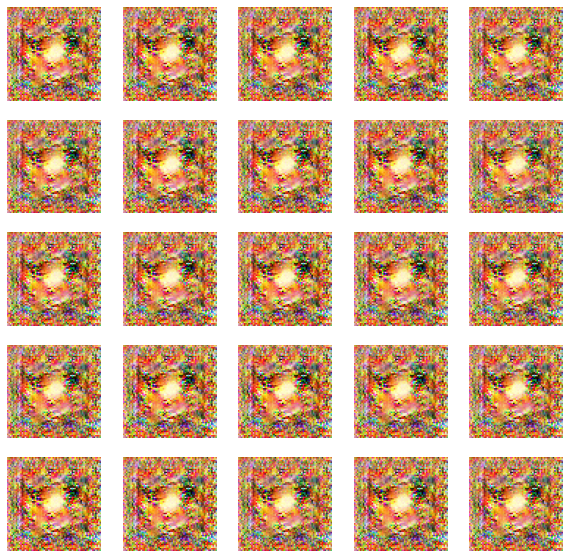

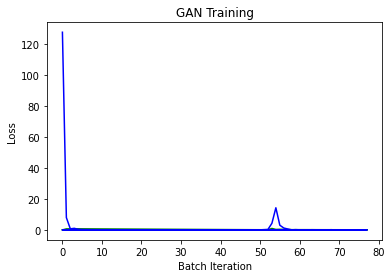

Epoch 32/2000 :
Batch 1/78 generator loss | discriminator loss : 1.153075118054403e-06 | 3.907867494490347e-06 - batch took 0.9802625179290771 s.
Batch 2/78 generator loss | discriminator loss : 1.2214069329274935e-06 | 2.6205572112303344e-06 - batch took 0.9808981418609619 s.
Batch 3/78 generator loss | discriminator loss : 8.938196742747095e-07 | 5.593402079284715e-06 - batch took 0.9760231971740723 s.
Batch 4/78 generator loss | discriminator loss : 1.3829686622557347e-06 | 2.4715710651435074e-06 - batch took 0.980349063873291 s.
Batch 5/78 generator loss | discriminator loss : 9.141648433796945e-07 | 2.490016186129651e-06 - batch took 0.9782743453979492 s.
Batch 6/78 generator loss | discriminator loss : 1.0436654065415496e-06 | 3.74346734588471e-06 - batch took 0.971714973449707 s.
Batch 7/78 generator loss | discriminator loss : 1.0422245395602658e-06 | 2.3317967361435876e-06 - batch took 0.9746983051300049 s.
Batch 8/78 generator loss | discriminator loss : 1.0252520041831303e-0

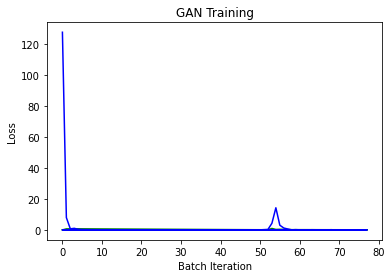

Epoch 33/2000 :
Batch 1/78 generator loss | discriminator loss : 1.0613888434818364e-06 | 3.017116569026257e-06 - batch took 0.9798469543457031 s.
Batch 2/78 generator loss | discriminator loss : 1.2678285656875232e-06 | 2.384936351518263e-06 - batch took 0.9785213470458984 s.
Batch 3/78 generator loss | discriminator loss : 1.4349909633892821e-06 | 3.643787124474329e-06 - batch took 0.9810373783111572 s.
Batch 4/78 generator loss | discriminator loss : 1.1952786280744476e-06 | 3.192038207089354e-06 - batch took 0.9824411869049072 s.
Batch 5/78 generator loss | discriminator loss : 1.1792457144110813e-06 | 2.7590515401243465e-06 - batch took 0.9739289283752441 s.
Batch 6/78 generator loss | discriminator loss : 1.1890701898664702e-06 | 2.4218155658672913e-06 - batch took 0.9758565425872803 s.
Batch 7/78 generator loss | discriminator loss : 1.116813336921041e-06 | 2.5167196326947305e-06 - batch took 0.9804277420043945 s.
Batch 8/78 generator loss | discriminator loss : 8.93450646799465

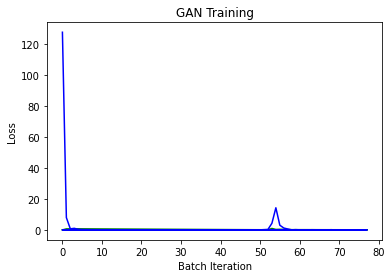

Epoch 34/2000 :
Batch 1/78 generator loss | discriminator loss : 1.0057030976895476e-06 | 3.4246767768308928e-06 - batch took 0.9793553352355957 s.
Batch 2/78 generator loss | discriminator loss : 8.836881306706346e-07 | 1.741983368219735e-06 - batch took 0.9804604053497314 s.
Batch 3/78 generator loss | discriminator loss : 7.932262064969109e-07 | 2.277870237321622e-06 - batch took 0.9735045433044434 s.
Batch 4/78 generator loss | discriminator loss : 9.9985243195988e-07 | 2.5409680688426306e-06 - batch took 0.9755659103393555 s.
Batch 5/78 generator loss | discriminator loss : 8.350581310878624e-07 | 1.609131004443043e-06 - batch took 0.9757874011993408 s.
Batch 6/78 generator loss | discriminator loss : 8.160455990946502e-07 | 2.515127960123209e-06 - batch took 0.9774248600006104 s.
Batch 7/78 generator loss | discriminator loss : 8.005405334188254e-07 | 1.6028843106141721e-06 - batch took 0.9855611324310303 s.
Batch 8/78 generator loss | discriminator loss : 7.425421131301846e-07 |

In [ ]:
gan = GAN()

gan.train(2000)

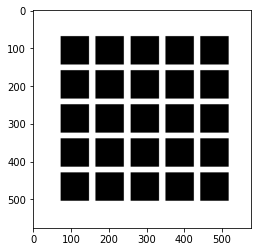

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg

img = mpimg.imread("animeGenerated/Faces_10.png")

plt.imshow(img)

